# Image features exercise
*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignment page](https://bcourses.berkeley.edu/courses/1453965/assignments/7738616) on the course website.*

We have seen that we can achieve reasonable performance on an image classification task by training a linear classifier on the pixels of the input image. In this exercise we will show that we can improve our classification performance by training linear classifiers not on raw pixels but on features that are computed from the raw pixels.

All of your work for this exercise will be done in this notebook.

In [1]:
import random
import numpy as np
from cs294_129.data_utils import load_CIFAR10
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## Load data
Similar to previous exercises, we will load CIFAR-10 data from disk.

In [2]:
from cs294_129.features import color_histogram_hsv, hog_feature

def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000):
  # Load the raw CIFAR-10 data
  cifar10_dir = 'cs294_129/datasets/cifar-10-batches-py'
  X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
  
  # Subsample the data
  mask = range(num_training, num_training + num_validation)
  X_val = X_train[mask]
  y_val = y_train[mask]
  mask = range(num_training)
  X_train = X_train[mask]
  y_train = y_train[mask]
  mask = range(num_test)
  X_test = X_test[mask]
  y_test = y_test[mask]

  return X_train, y_train, X_val, y_val, X_test, y_test

X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data()

## Extract Features
For each image we will compute a Histogram of Oriented
Gradients (HOG) as well as a color histogram using the hue channel in HSV
color space. We form our final feature vector for each image by concatenating
the HOG and color histogram feature vectors.

Roughly speaking, HOG should capture the texture of the image while ignoring
color information, and the color histogram represents the color of the input
image while ignoring texture. As a result, we expect that using both together
ought to work better than using either alone. Verifying this assumption would
be a good thing to try for the bonus section.

The `hog_feature` and `color_histogram_hsv` functions both operate on a single
image and return a feature vector for that image. The extract_features
function takes a set of images and a list of feature functions and evaluates
each feature function on each image, storing the results in a matrix where
each column is the concatenation of all feature vectors for a single image.

In [3]:
from cs294_129.features import *

num_color_bins = 10 # Number of bins in the color histogram
feature_fns = [hog_feature, lambda img: color_histogram_hsv(img, nbin=num_color_bins)]
X_train_feats = extract_features(X_train, feature_fns, verbose=True)
X_val_feats = extract_features(X_val, feature_fns)
X_test_feats = extract_features(X_test, feature_fns)

# Preprocessing: Subtract the mean feature
mean_feat = np.mean(X_train_feats, axis=0, keepdims=True)
X_train_feats -= mean_feat
X_val_feats -= mean_feat
X_test_feats -= mean_feat

# Preprocessing: Divide by standard deviation. This ensures that each feature
# has roughly the same scale.
std_feat = np.std(X_train_feats, axis=0, keepdims=True)
X_train_feats /= std_feat
X_val_feats /= std_feat
X_test_feats /= std_feat

# Preprocessing: Add a bias dimension
X_train_feats = np.hstack([X_train_feats, np.ones((X_train_feats.shape[0], 1))])
X_val_feats = np.hstack([X_val_feats, np.ones((X_val_feats.shape[0], 1))])
X_test_feats = np.hstack([X_test_feats, np.ones((X_test_feats.shape[0], 1))])

Done extracting features for 1000 / 49000 images
Done extracting features for 2000 / 49000 images
Done extracting features for 3000 / 49000 images
Done extracting features for 4000 / 49000 images
Done extracting features for 5000 / 49000 images
Done extracting features for 6000 / 49000 images
Done extracting features for 7000 / 49000 images
Done extracting features for 8000 / 49000 images
Done extracting features for 9000 / 49000 images
Done extracting features for 10000 / 49000 images
Done extracting features for 11000 / 49000 images
Done extracting features for 12000 / 49000 images
Done extracting features for 13000 / 49000 images
Done extracting features for 14000 / 49000 images
Done extracting features for 15000 / 49000 images
Done extracting features for 16000 / 49000 images
Done extracting features for 17000 / 49000 images
Done extracting features for 18000 / 49000 images
Done extracting features for 19000 / 49000 images
Done extracting features for 20000 / 49000 images
Done extr

## Train SVM on features
Using the multiclass SVM code developed earlier in the assignment, train SVMs on top of the features extracted above; this should achieve better results than training SVMs directly on top of raw pixels.

In [4]:
# Use the validation set to tune the learning rate and regularization strength

from cs294_129.classifiers.linear_classifier import LinearSVM

learning_rates = [1e-9, 1e-8, 1e-7]
regularization_strengths = [1e5, 1e6, 1e7]

results = {}
best_val = -1
best_svm = None

pass
################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained classifer in best_svm. You might also want to play          #
# with different numbers of bins in the color histogram. If you are careful    #
# you should be able to get accuracy of near 0.44 on the validation set.       #
################################################################################
for lr in learning_rates:
    for rg in regularization_strengths:
        classifier = LinearSVM()
        classifier.train(X_train_feats, y_train, learning_rate=lr, reg=rg,
                      num_iters=1500, verbose=True)
        y_pred_train = classifier.predict(X_train_feats)
        y_pred_val = classifier.predict(X_val_feats)
        y_acc_train = np.mean(y_pred_train == y_train)
        y_acc_val = np.mean(y_pred_val == y_val)
        if best_val < y_acc_val:
            best_val = y_acc_val
            best_svm = classifier
        results[(lr, rg)] = (y_acc_train, y_acc_val)
################################################################################
#                              END OF YOUR CODE                                #
################################################################################

# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print 'lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy)
    
print 'best validation accuracy achieved during cross-validation: %f' % best_val

iteration 0 / 1500: loss 85.615834
iteration 100 / 1500: loss 84.101778
iteration 200 / 1500: loss 82.620579
iteration 300 / 1500: loss 81.160145
iteration 400 / 1500: loss 79.744770
iteration 500 / 1500: loss 78.336139
iteration 600 / 1500: loss 76.965560
iteration 700 / 1500: loss 75.613222
iteration 800 / 1500: loss 74.301897
iteration 900 / 1500: loss 73.007558
iteration 1000 / 1500: loss 71.739335
iteration 1100 / 1500: loss 70.495722
iteration 1200 / 1500: loss 69.265490
iteration 1300 / 1500: loss 68.089545
iteration 1400 / 1500: loss 66.903579
iteration 0 / 1500: loss 786.431898
iteration 100 / 1500: loss 645.436360
iteration 200 / 1500: loss 530.021529
iteration 300 / 1500: loss 435.534549
iteration 400 / 1500: loss 358.186760
iteration 500 / 1500: loss 294.858013
iteration 600 / 1500: loss 243.016155
iteration 700 / 1500: loss 200.572185
iteration 800 / 1500: loss 165.829013
iteration 900 / 1500: loss 137.400644
iteration 1000 / 1500: loss 114.111511
iteration 1100 / 1500: lo

In [6]:
# Evaluate your trained SVM on the test set
y_test_pred = best_svm.predict(X_test_feats)
test_accuracy = np.mean(y_test == y_test_pred)
print test_accuracy

0.425


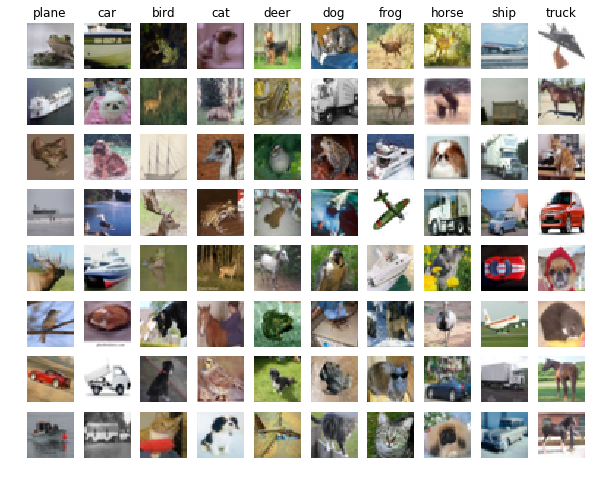

In [7]:
# An important way to gain intuition about how an algorithm works is to
# visualize the mistakes that it makes. In this visualization, we show examples
# of images that are misclassified by our current system. The first column
# shows images that our system labeled as "plane" but whose true label is
# something other than "plane".

examples_per_class = 8
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for cls, cls_name in enumerate(classes):
    idxs = np.where((y_test != cls) & (y_test_pred == cls))[0]
    idxs = np.random.choice(idxs, examples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt.subplot(examples_per_class, len(classes), i * len(classes) + cls + 1)
        plt.imshow(X_test[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls_name)
plt.show()

### Inline question 1:
Describe the misclassification results that you see. Do they make sense?

## Neural Network on image features
Earlier in this assigment we saw that training a two-layer neural network on raw pixels achieved better classification performance than linear classifiers on raw pixels. In this notebook we have seen that linear classifiers on image features outperform linear classifiers on raw pixels. 

For completeness, we should also try training a neural network on image features. This approach should outperform all previous approaches: you should easily be able to achieve over 55% classification accuracy on the test set; our best model achieves about 60% classification accuracy.

In [8]:
print X_train_feats.shape

(49000, 155)


In [11]:
from cs294_129.classifiers.neural_net import TwoLayerNet

input_dim = X_train_feats.shape[1]
hidden_dim = 500
num_classes = 10

net = TwoLayerNet(input_dim, hidden_dim, num_classes)
best_net = None
best_val = -1
best_stat = None
################################################################################
# TODO: Train a two-layer neural network on image features. You may want to    #
# cross-validate various parameters as in previous sections. Store your best   #
# model in the best_net variable.                                              #
################################################################################
learning_rates = np.logspace(-10,0, 5)
reg_strength = np.logspace(-3,5,5)
results ={}
iters =2000
for lr in learning_rates:
    for reg in reg_strength:
        
        stats = net.train(X_train_feats, y_train, X_val_feats, y_val,
                    num_iters=iters, batch_size=200,
                    learning_rate=lr, learning_rate_decay=0.95,
                    reg= reg, verbose=True)
        y_train_pred = net.predict(X_train_feats)
        y_val_pred = net.predict(X_val_feats)
        acc_train = np.mean(y_train_pred == y_train)
        acc_val = np.mean(y_val_pred == y_val)
        results[(lr,reg)] = (acc_train, acc_val)
        if best_val < acc_val:
            best_val = acc_val
            best_stat = stats
            best_net = net
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print 'lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy)
    
print 'best validation accuracy achieved during cross-validation: %f' % best_val
################################################################################
#                              END OF YOUR CODE                                #
################################################################################

iteration 0 / 2000: loss 2.302585
iteration 100 / 2000: loss 2.302585
iteration 200 / 2000: loss 2.302586
iteration 300 / 2000: loss 2.302586
iteration 400 / 2000: loss 2.302586
iteration 500 / 2000: loss 2.302586
iteration 600 / 2000: loss 2.302586
iteration 700 / 2000: loss 2.302586
iteration 800 / 2000: loss 2.302586
iteration 900 / 2000: loss 2.302586
iteration 1000 / 2000: loss 2.302585
iteration 1100 / 2000: loss 2.302586
iteration 1200 / 2000: loss 2.302586
iteration 1300 / 2000: loss 2.302586
iteration 1400 / 2000: loss 2.302585
iteration 1500 / 2000: loss 2.302586
iteration 1600 / 2000: loss 2.302586
iteration 1700 / 2000: loss 2.302585
iteration 1800 / 2000: loss 2.302586
iteration 1900 / 2000: loss 2.302586
iteration 0 / 2000: loss 2.302626
iteration 100 / 2000: loss 2.302627
iteration 200 / 2000: loss 2.302626
iteration 300 / 2000: loss 2.302627
iteration 400 / 2000: loss 2.302626
iteration 500 / 2000: loss 2.302626
iteration 600 / 2000: loss 2.302627
iteration 700 / 2000: 

iteration 500 / 2000: loss 2.302585
iteration 600 / 2000: loss 2.302585
iteration 700 / 2000: loss 2.302585
iteration 800 / 2000: loss 2.302586
iteration 900 / 2000: loss 2.302585
iteration 1000 / 2000: loss 2.302585
iteration 1100 / 2000: loss 2.302585
iteration 1200 / 2000: loss 2.302585
iteration 1300 / 2000: loss 2.302584
iteration 1400 / 2000: loss 2.302585
iteration 1500 / 2000: loss 2.302585
iteration 1600 / 2000: loss 2.302586
iteration 1700 / 2000: loss 2.302585
iteration 1800 / 2000: loss 2.302584
iteration 1900 / 2000: loss 2.302585
iteration 0 / 2000: loss 2.302585
iteration 100 / 2000: loss 2.302586
iteration 200 / 2000: loss 2.302585
iteration 300 / 2000: loss 2.302586
iteration 400 / 2000: loss 2.302585
iteration 500 / 2000: loss 2.302586
iteration 600 / 2000: loss 2.302585
iteration 700 / 2000: loss 2.302585
iteration 800 / 2000: loss 2.302585
iteration 900 / 2000: loss 2.302587
iteration 1000 / 2000: loss 2.302587
iteration 1100 / 2000: loss 2.302584
iteration 1200 / 2

cs294_129/classifiers/neural_net.py:86: RuntimeWarning: overflow encountered in exp
  expData = np.exp(scores)
cs294_129/classifiers/neural_net.py:87: RuntimeWarning: invalid value encountered in divide
  probs = expData/ np.sum(expData, axis = 1, keepdims = True)
cs294_129/classifiers/neural_net.py:99: RuntimeWarning: divide by zero encountered in log
  logProbs = -np.log(probs[range(N), y])
cs294_129/classifiers/neural_net.py:119: RuntimeWarning: invalid value encountered in less_equal
  dhidden[a1 <=0] = 0


iteration 100 / 2000: loss nan
iteration 200 / 2000: loss nan
iteration 300 / 2000: loss nan
iteration 400 / 2000: loss nan
iteration 500 / 2000: loss nan
iteration 600 / 2000: loss nan
iteration 700 / 2000: loss nan
iteration 800 / 2000: loss nan
iteration 900 / 2000: loss nan
iteration 1000 / 2000: loss nan
iteration 1100 / 2000: loss nan
iteration 1200 / 2000: loss nan
iteration 1300 / 2000: loss nan
iteration 1400 / 2000: loss nan
iteration 1500 / 2000: loss nan
iteration 1600 / 2000: loss nan
iteration 1700 / 2000: loss nan
iteration 1800 / 2000: loss nan
iteration 1900 / 2000: loss nan
iteration 0 / 2000: loss nan
iteration 100 / 2000: loss nan
iteration 200 / 2000: loss nan
iteration 300 / 2000: loss nan
iteration 400 / 2000: loss nan
iteration 500 / 2000: loss nan
iteration 600 / 2000: loss nan
iteration 700 / 2000: loss nan
iteration 800 / 2000: loss nan
iteration 900 / 2000: loss nan
iteration 1000 / 2000: loss nan
iteration 1100 / 2000: loss nan
iteration 1200 / 2000: loss n

In [14]:
# Run your neural net classifier on the test set. You should be able to
# get more than 55% accuracy.

test_acc = (net.predict(X_test_feats) == y_test).mean()
print test_acc

0.103


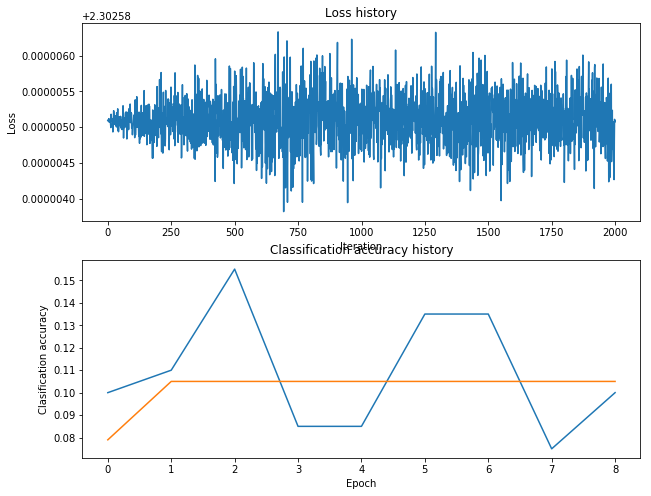

In [17]:
plt.subplot(2, 1, 1)
plt.plot(best_stat['loss_history'])
plt.title('Loss history')
plt.xlabel('Iteration')
plt.ylabel('Loss')

plt.subplot(2, 1, 2)
plt.plot(best_stat['train_acc_history'], label='train')
plt.plot(best_stat['val_acc_history'], label='val')
plt.title('Classification accuracy history')
plt.xlabel('Epoch')
plt.ylabel('Clasification accuracy')
plt.show()

# Bonus: Design your own features!

You have seen that simple image features can improve classification performance. So far we have tried HOG and color histograms, but other types of features may be able to achieve even better classification performance.

For bonus points, design and implement a new type of feature and use it for image classification on CIFAR-10. Explain how your feature works and why you expect it to be useful for image classification. Implement it in this notebook, cross-validate any hyperparameters, and compare its performance to the HOG + Color histogram baseline.

# Bonus: Do something extra!
Use the material and code we have presented in this assignment to do something interesting. Was there another question we should have asked? Did any cool ideas pop into your head as you were working on the assignment? This is your chance to show off!